<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import pytorch
import torch
from torch import nn
print(f"pytorch version: {torch.__version__}")

pytorch version: 1.12.1+cu113


In [2]:
# first model is trained on the cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
print(f"torchvision version: {torchvision.__version__}") 

torchvision version: 0.13.1+cu113


In [4]:
# install torchmetrics from evaluating models
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# import matplotlib
import matplotlib.pyplot as plt

In [6]:
# import fashion MNIST training data
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor(), target_transform=None)

In [7]:
# dataset information
print(f"Number of training instances: {len(train_data.data)}")
print(f"Number of training targets: {len(train_data.targets)}")
print(f"Number of test instances: {len(test_data.data)}")
print(f"Number of test targets: {len(test_data.targets)}")
print(f"Number of classes: {len(train_data.classes)}")
print(train_data.classes)

Number of training instances: 60000
Number of training targets: 60000
Number of test instances: 10000
Number of test targets: 10000
Number of classes: 10
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


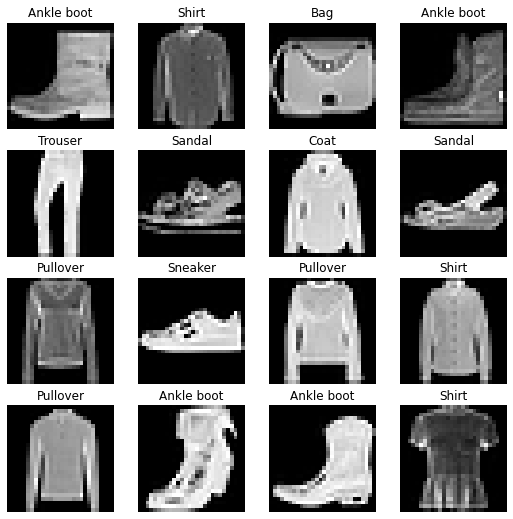

In [8]:
# display 12 random images from the training set
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  # create a random scalar tensor index
  random_idx = torch.randint(0, len(train_data), size=[1]).item() # item() to convert integer tensor to scalar
  image, label = train_data[random_idx] # choose random data pair from data set
  fig.add_subplot(rows, cols, i) # subplots are non-zero indexed
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)

In [9]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# divide the data sets into batches stored in data loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE)

print(f"Number of batches for training data: {len(train_loader)}") # 32 * 1875 = 60000
print(f"Number of batches for test data: {len(test_loader)}")


Number of batches for training data: 1875
Number of batches for test data: 313


In [10]:
# get next training batch from data loader
train_image_batch, train_label_batch = next(iter(train_loader))
print(f"training image batch size: {train_image_batch.shape}")
print(f"training label batch size: {train_label_batch.shape}")

training image batch size: torch.Size([32, 1, 28, 28])
training label batch size: torch.Size([32])


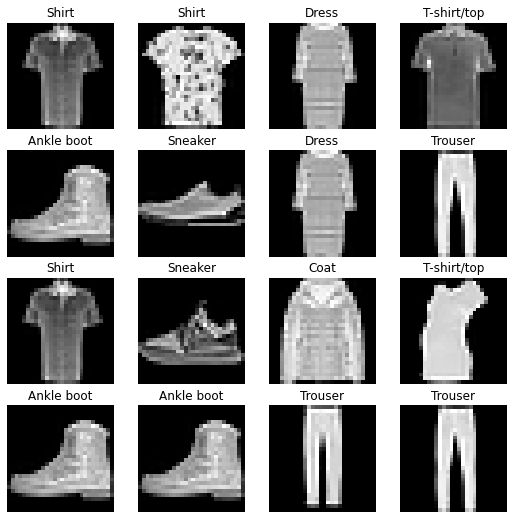

In [11]:
# display 12 random images from the first training set batch of the data loader
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
  # create a random scalar tensor index
  random_idx = torch.randint(0, len(train_image_batch), size=[1]).item()
  image, label = train_image_batch[random_idx], train_label_batch[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train_data.classes[label])
  plt.axis(False)

In [12]:
# simple linear model
class SimpleLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Flatten()
    self.layer2 = nn.Linear(in_features=784, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=10)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

# instantiate model
torch.manual_seed(42)
model_1 = SimpleLinearModel().to(device)

In [13]:
# set up loss
loss_func = nn.CrossEntropyLoss()
# set up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
# setup accuracy metric
accuracy_func = Accuracy().to(device)

In [14]:
torch.manual_seed(42)

epochs = 5

# loop epoch
for epoch in range(epochs):
  train_loss = 0
  train_acc = 0
  # loop each batch in the train data loader
  for batch, (X, y) in enumerate(train_loader):
    X, y = X.to(device), y.to(device)

    model_1.train()
    # forward pass
    train_logits = model_1(X)
    train_labels = torch.argmax(torch.softmax(train_logits, dim=1), dim=1)
    
    # calculate loss
    loss = loss_func(train_logits, y)
    train_loss += loss
    train_acc += accuracy_func(train_labels, y)

    # zero grad
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # gradient descent
    optimizer.step()
  
  # calculate the average batch training loss for epoch
  train_loss /= len(train_loader)
  train_acc /= len(train_loader)

  # testing loop
  test_loss = 0
  test_acc = 0

  model_1.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(test_loader):
      X, y = X.to(device), y.to(device)
      
      test_logits = model_1(X)
      test_labels = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      
      batch_test_loss = loss_func(test_logits, y)
      test_loss += batch_test_loss
      
      test_acc += accuracy_func(test_labels, y)

    # calculations on test metrics must happen within inference_mode()
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

  print(f"epoch: {epoch} | train loss: {train_loss:.5f} | train accuracy: {train_acc:.2f}% | test loss: {test_loss:.5f} | test accuracy {test_acc:.2f}%")


epoch: 0 | train loss: 0.59039 | train accuracy: 0.79% | test loss: 0.50954 | test accuracy 0.82%
epoch: 1 | train loss: 0.47633 | train accuracy: 0.83% | test loss: 0.47989 | test accuracy 0.83%
epoch: 2 | train loss: 0.45503 | train accuracy: 0.84% | test loss: 0.47664 | test accuracy 0.83%
epoch: 3 | train loss: 0.44251 | train accuracy: 0.84% | test loss: 0.46306 | test accuracy 0.84%
epoch: 4 | train loss: 0.43582 | train accuracy: 0.85% | test loss: 0.46869 | test accuracy 0.83%


In [15]:
# create model evaulate function for reuse
def evaluate_model(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn, device: torch.device = device):
  # dataset metrics
  test_loss = 0
  test_acc = 0
  
  model.eval()
  with torch.inference_mode():
    # loop each batch of the test data
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # calculate batch outputs
      test_logits = model(X) 
      test_labels = torch.argmax(torch.softmax(test_logits, dim=1), dim=1)
      # calculate batch loss
      batch_test_loss = loss_fn(test_logits, y)
      # accumulate loss for dataset
      test_loss += batch_test_loss
      # accumulate accuacy for dataset
      test_acc += acc_fn(test_labels, y)

    # average batch results across entire dataset
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    # return dictionary of results
    return {'model name':model.__class__.__name__, 'model_loss':test_loss.item(), 'model_accuracy':test_acc.item() * 100}

In [16]:
model_1_results = evaluate_model(model_1, test_loader, loss_func, accuracy_func)
print(model_1_results)

{'model name': 'SimpleLinearModel', 'model_loss': 0.46869388222694397, 'model_accuracy': 83.26677083969116}


In [17]:
# simple non-linear model
class SimpleNonLinearModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Flatten()
    self.layer2 = nn.Linear(in_features=784, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=10)
    self.relu = nn.ReLU()

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.relu(self.layer3(self.relu(self.layer2(self.layer1(x)))))

# instantiate model
torch.manual_seed(42)
model_2 = SimpleNonLinearModel().to(device)

In [18]:
# setup loss function
loss_func = nn.CrossEntropyLoss()
# setup optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)
# setup accuracy metric
accuracy_func = Accuracy().to(device)

In [19]:
# create training step function for reuse
def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn, device: torch.device = device):
  train_loss, train_accuracy = 0, 0
  # loop batches
  for batch, (X, y) in enumerate(dataloader):
    # allocate batch to device
    X = X.to(device)
    y = y.to(device)

    model.train()
    # forward pass
    logits = model(X)
    # softmax for multi-class classification
    labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)

    # calculate and store loss
    loss = loss_fn(logits, y)
    train_loss += loss

    # calculate and store accuracy
    train_accuracy += acc_fn(labels, y)

    # zero grad
    optimizer.zero_grad()

    # back propagation
    loss.backward()

    # gradient descent
    optimizer.step()

  # average loss and accuracy for entire dataset
  train_loss /= len(dataloader)
  train_accuracy /= len(dataloader)

  print(f"train loss: {train_loss:.5f} | train_accuracy: {train_accuracy:.2f}%")

# create testing step function for reuse
def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acc_fn, device: torch.device = device):
  test_loss, test_accuracy = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      # allocate data to device
      X, y = X.to(device), y.to(device)

      # forward pass
      logits = model(X)
      labels = torch.argmax(torch.softmax(logits, dim=1), dim=1)

      # calculate and store loss
      loss = loss_fn(logits, y)
      test_loss += loss
      # calculate and store accuracy
      test_accuracy += acc_fn(labels, y)

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f"test loss: {test_loss:.5f} | test accuracy: {test_accuracy:.2f}%")


In [20]:
epochs = 3
# train and test model using train and test function
for epoch in range(epochs):
  print(f"epoch: {epoch}")

  train_step(model_2, train_loader, loss_func, accuracy_func, device)
  test_step(model_2, test_loader, loss_func, accuracy_func, device)

epoch: 0
train loss: 1.05878 | train_accuracy: 0.62%
test loss: 0.99506 | test accuracy: 0.64%
epoch: 1
train loss: 0.91331 | train_accuracy: 0.66%
test loss: 0.90508 | test accuracy: 0.67%
epoch: 2
train loss: 0.87982 | train_accuracy: 0.67%
test loss: 0.89476 | test accuracy: 0.66%


In [21]:
model_2_results = evaluate_model(model_2, test_loader, loss_func, accuracy_func, device)
print(model_2_results)

{'model name': 'SimpleNonLinearModel', 'model_loss': 0.8947636485099792, 'model_accuracy': 66.46365523338318}


In [22]:
# custom convolutional network based on TinyVGG
class ConvolutionalNeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2) # default stride is the same as the kernel size
    )
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=10*7*7, out_features=10)
    )

  def forward(self, x):
    return self.fc(self.block2(self.block1(x)))

# instantiate model
torch.manual_seed(42)
model_3 = ConvolutionalNeuralNetwork().to(device)

In [23]:
# experiment with convolution layer
torch.manual_seed(42)

# [batch, channels, width, height]
x = torch.randn((3, 64 ,64)).unsqueeze(dim=0) # add single batch dimension
print(x.shape) # [1, 3, 64, 64]

conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
print(conv_layer(x).shape) # [1, 10, 62, 62]

# new output shape = ({[n - k + 2p] / s} + 1, {[n - k + 2p] / s} + 1)

torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 62, 62])


In [24]:
# experiment with max pooling layer
torch.manual_seed(42)

x = torch.randn((3, 64, 64)).unsqueeze(dim=0)
print(x.shape) # [1, 3, 64, 64]

max_pool = nn.MaxPool2d(kernel_size=2) # stride is same as kernel size by default
print(max_pool(x).shape) # [1, 3, 32, 32]

x = torch.randn((1, 2, 2)).unsqueeze(dim=0)
print(x)
print(x.shape)

y = max_pool(x)
print(y) # select the highest value in the 2x2 kernel
print(y.shape) # [1, 1, 1, 1]

torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 32, 32])
tensor([[[[ 0.7264, -0.4500],
          [ 0.4298,  0.3540]]]])
torch.Size([1, 1, 2, 2])
tensor([[[[0.7264]]]])
torch.Size([1, 1, 1, 1])


In [25]:
# experiment with average pooling
torch.manual_seed(42)

x = torch.randn((1, 2, 2)).unsqueeze(dim=0)
print(x)
print(x.shape) # [1, 1, 2, 2]

avg_pool = nn.AvgPool2d(kernel_size=2) # stride is the same as kernel size by default

y = avg_pool(x)
print(y) # select the average of all values within the kernel space
print(y) # [1, 1, 1, 1]

tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
torch.Size([1, 1, 2, 2])
tensor([[[[0.2326]]]])
tensor([[[[0.2326]]]])


In [26]:
# set up loss function
loss_func = nn.CrossEntropyLoss()
# set up optimizer
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)
# set up accuracy metric
accuracy = Accuracy().to(device)

In [27]:
# train and test loop
epochs = 3

for epoch in range(epochs):
  print(f"epoch: {epoch}")
  train_step(model_3, train_loader, loss_func, accuracy_func, device)
  test_step(model_3, test_loader, loss_func, accuracy_func, device)

epoch: 0
train loss: 0.58227 | train_accuracy: 0.79%
test loss: 0.43141 | test accuracy: 0.84%
epoch: 1
train loss: 0.35265 | train_accuracy: 0.87%
test loss: 0.34488 | test accuracy: 0.88%
epoch: 2
train loss: 0.31474 | train_accuracy: 0.89%
test loss: 0.33231 | test accuracy: 0.88%


In [28]:
# evaluate model 3 results
model_3_results = evaluate_model(model_3, test_loader, loss_func, accuracy_func, device)
print(model_3_results)

{'model name': 'ConvolutionalNeuralNetwork', 'model_loss': 0.3323083817958832, 'model_accuracy': 87.8494381904602}


                   model name  model_loss  model_accuracy
0           SimpleLinearModel    0.468694       83.266771
1        SimpleNonLinearModel    0.894764       66.463655
2  ConvolutionalNeuralNetwork    0.332308       87.849438


Text(0, 0.5, 'Model')

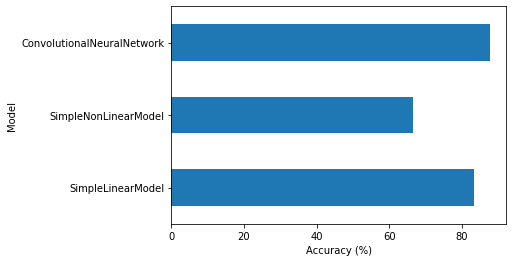

In [29]:
# combine results of all three models
import pandas as pd
# create combined data frame
results = pd.DataFrame([model_1_results, model_2_results, model_3_results])
print(results)

# compare the accuracy of each model
results.set_index(['model name'])['model_accuracy'].plot(kind='barh')
plt.xlabel('Accuracy (%)')
plt.ylabel('Model')

### Evaluate random predictions made by a model

In [30]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
  pred_probabilities = [] # store the softmax probabilities for each sample
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # return tesnor with single a batch dimension using the sample and allocate to the device
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # prediction logits
      pred_logits = model(sample)

      # calculate probabilites of each class for the sample using softmax
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0) # unsqueeze to remove batch dimension

      # store probabilites
      pred_probabilities.append(pred_prob.cpu()) # allocate to cpu for numpy and/or matplotlib
  
  # stack probabilities into vector tensor
  return torch.stack(pred_probabilities)

In [31]:
import random

random.seed(42)

test_samples = []
test_labels = []

# choose 9 random sample and label pairs from the test dataset
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [32]:
# make predictions on random data using a specific model
pred_probabilities = make_predictions(model_3, test_samples, device)
print(pred_probabilities)

tensor([[5.7862e-08, 1.2982e-09, 7.8743e-09, 1.2540e-08, 1.6788e-09, 9.9999e-01,
         1.3115e-07, 1.9509e-08, 1.4620e-06, 1.0484e-05],
        [5.9128e-02, 6.9506e-01, 3.0499e-03, 4.6097e-02, 1.6648e-01, 7.8357e-05,
         2.8398e-02, 7.3174e-05, 1.6132e-03, 1.6774e-05],
        [2.6756e-04, 1.3817e-06, 1.0090e-04, 3.7630e-05, 3.6892e-06, 3.1875e-03,
         1.1949e-04, 8.3499e-01, 6.9090e-03, 1.5439e-01],
        [6.0840e-04, 3.3146e-04, 1.5143e-01, 2.3443e-04, 8.4677e-01, 9.6704e-08,
         5.6158e-04, 1.6681e-07, 6.3142e-05, 6.7773e-07],
        [2.1056e-02, 1.0570e-05, 1.5394e-04, 9.7209e-01, 9.7773e-05, 3.5029e-07,
         6.5234e-03, 2.9468e-06, 5.9722e-05, 2.9791e-06],
        [5.1932e-01, 1.0845e-05, 2.1818e-03, 2.0001e-03, 2.7259e-03, 2.8020e-07,
         4.7325e-01, 5.2760e-07, 5.1354e-04, 4.9466e-08],
        [8.6792e-05, 2.2355e-05, 2.5709e-02, 2.0932e-06, 9.0552e-01, 6.2912e-08,
         6.7777e-02, 1.9759e-09, 8.8261e-04, 4.0862e-07],
        [8.3569e-06, 2.3748

In [33]:
# convert predictions probabilities into predicted labels
pred_classes = pred_probabilities.argmax(dim=1)
print(pred_classes)

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])


In [34]:
# print the actual labels for the test samples
print(test_labels)

[5, 1, 7, 4, 3, 0, 4, 7, 1]


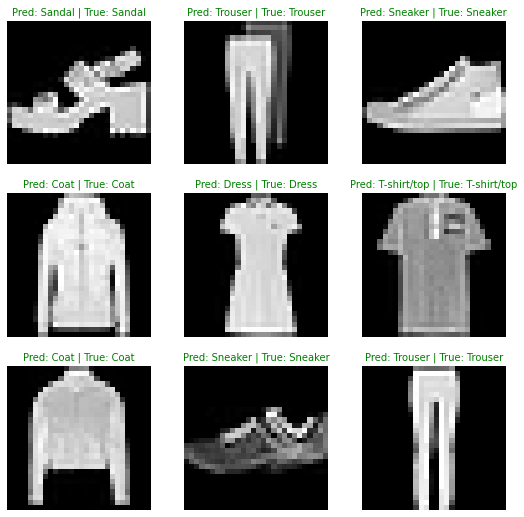

In [35]:
# plot test predicitions against real targets
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples): # return index and value of elements within a list
  # create subplot
  plt.subplot(nrows, ncols, i+1)
  # plot the sample image as greyscale
  plt.imshow(sample.squeeze(), cmap='gray')
  
  # text for predicted label
  pred_label = test_data.classes[pred_classes[i]]
  # text for true label
  true_label = test_data.classes[test_labels[i]]

  subplot_title = f"Pred: {pred_label} | True: {true_label}"
  # change the colour of the subplot title if predicted label is the same as the true label
  if pred_label == true_label:
    plt.title(subplot_title, fontsize=10, c='g')
  else:
    plt.title(subplot_title, fontsize=10, c='r')
  plt.axis(False)


### Creating a confusion matrix

In [36]:
# import progress bar
from tqdm.auto import tqdm

# making predictions with the convolutional neural network model
y_preds = []
model_3.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc='predictions'):
    X, y = X.to(device), y.to(device) # allocate data to GPU

    # logit output
    y_logits = model_3(X)
    # label output
    y_labels = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    y_preds.append(y_labels.cpu())
  
# concatenate list of predictions into one single tensor
y_pred_tensor = torch.cat(y_preds)

predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [37]:
# check if torchmetrics is installed
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  # mlztend version should be 0.19.0 or higher
  assert int(mlxtend.__version__.split('.')[1]) >= 19
except:
  !pip install torchmetrics -U mlxtend # runtime restart required
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}") # mlxtend version 19 or higher

mlxtend version: 0.21.0


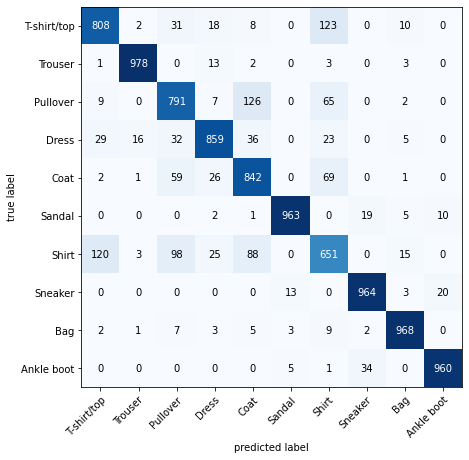

In [38]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# instantiate confusion matrix
confusion_matrix = ConfusionMatrix(num_classes=len(train_data.classes))
# compare predictions to targets
confusion_matrix_tensor = confusion_matrix(preds=y_pred_tensor, target=test_data.targets)

# plot confusion matrix
fig, ax = plot_confusion_matrix(confusion_matrix_tensor.numpy(), class_names=train_data.classes, figsize=(10,7))

A confusion matrix shows good classification accuracy of a model, if the number in the diagonals are large, and all other cells are zero.

The convolutional neural network model shows poorer performance distinguishing between t-shirts and shirts as well as t-shirts and pullovers.

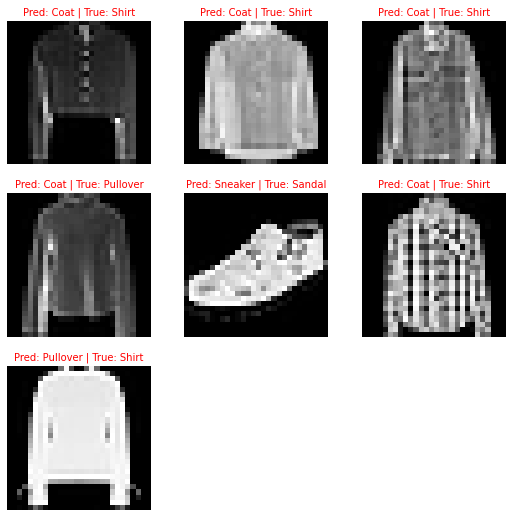

In [39]:
import random

random.seed(10)
test_samples = []
test_labels = []

# choose 50 random sample and label pairs from the test dataset
for sample, label in random.sample(list(test_data), k=50):
  test_samples.append(sample)
  test_labels.append(label)

# make predictions on random data using a specific model
pred_probabilities = make_predictions(model_3, test_samples, device)

# convert predictions probabilities into predicted labels
pred_classes = pred_probabilities.argmax(dim=1)

# plot up to 9 incorrect test predicitions against real targets
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
j = 1

for i, sample in enumerate(test_samples): # return index and value of elements within a list
  # text for predicted label
  pred_label = test_data.classes[pred_classes[i]]
  # text for true label
  true_label = test_data.classes[test_labels[i]]

  if (pred_label != true_label):
    # create subplot
    plt.subplot(nrows, ncols, j)
    # plot the sample image as greyscale
    plt.imshow(sample.squeeze(), cmap='gray')
  
    subplot_title = f"Pred: {pred_label} | True: {true_label}"
    plt.title(subplot_title, fontsize=10, c='r')
    plt.axis(False)
    # update subplot index
    j = j+1


The model struggles to classifier fashion items that look similar (e.g. pullovers with t-shirts/tops and sneakers with sandals)

This is evidence of data error leading to poorer accuracy, as these items are very closely related. The model performance is very good for items that are different. The model could therefore be improved if samples and labels were further from each other, rtaher than there being a problem with the CNN itself.

### Save and load a model

In [40]:
# save model

from pathlib import Path

# create models directory if it does not exist
MODEL_PATH = Path('Models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# create the model save path
MODEL_NAME = 'convolutional_neural_network.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Model saved to {MODEL_SAVE_PATH}")
# save model state dict
torch.save(obj=model_3.state_dict(), f=MODEL_SAVE_PATH)

Model saved to Models/convolutional_neural_network.pth


In [41]:
# load model

# create new instance of convolutional neural network
model_4 = ConvolutionalNeuralNetwork()

# load state dict of previously saved model
model_4.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
# allocate to GPU
model_4 = model_4.to(device)

In [42]:
# evaluate and compare both convolutional neural networks
torch.manual_seed(42)

model_4_results = evaluate_model(model_4, test_loader, loss_func, accuracy_func, device)
print(model_4_results)

{'model name': 'ConvolutionalNeuralNetwork', 'model_loss': 0.3323083817958832, 'model_accuracy': 87.8494381904602}


In [43]:
# using torch.isclose() to compare the similarity of the results for both models within some tolerance
torch.isclose(torch.tensor(model_4_results['model_accuracy']), torch.tensor(model_3_results['model_accuracy']), atol=1e-08)

tensor(True)